In [1]:
import torch

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tools as tl

In [2]:
encoder = tl.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, 
                            num_layers=2)
encoder.eval()
X  = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [3]:
decoder = tl.Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                            num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [4]:
X = torch.tensor([[1, 2, 3], [4, 5, 0]])
tl.sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [5]:
X = torch.ones(2, 3, 4)
tl.sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [6]:
loss = tl.MaskedSortmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), 
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

loss  0.020,  24932.2 tokens/sec on cuda:0


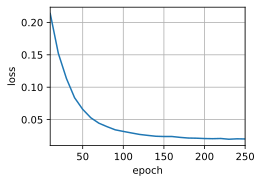

In [7]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, tl.try_gpu()
train_iter, src_vocab, tgt_vocab = tl.load_data_nmt(batch_size, num_steps)
encoder = tl.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, 
                            dropout)
decoder = tl.Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                            dropout)
net = tl.EncoderDecoder(encoder, decoder)
tl.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [8]:
engs = ['go .', "i lost .", 'he\'s home .', 'i\'m a student .']
fras = ['va !', 'j\'ai perdu .', 'il est chez lui .', 'je suis étudiant .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = tl.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, ', f'bleu {tl.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai froid .,  bleu 0.000
he's home . => il court .,  bleu 0.000
i'm a student . => je suis <unk> .,  bleu 0.658
